### Construct Kinematic Chain using `networkx` package

In [1]:
import copy,cv2,glob,os
import numpy as np
import mediapy as media
import networkx as nx
import matplotlib.pyplot as plt
from util import r2rpy,rpy2r,rodrigues,create_folder_if_not_exists
from mujoco_parser import MuJoCoParserClass
from kin_chain import KinematicChainClass
from networkx.algorithms.traversal.depth_first_search import dfs_edges
np.set_printoptions(precision=2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("networkx version:[%s]"%(nx.__version__))

Ready.
networkx version:[3.1]


### Initialize kinematic chain

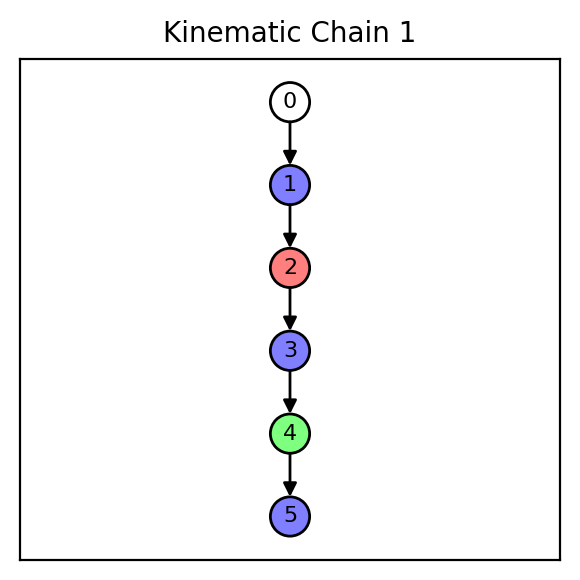

[0/6] joint name:[Base] p:[0 0 0] rpy_deg:[0. 0. 0.]
[1/6] joint name:[Joint1] p:[0.  0.  0.2] rpy_deg:[ 0. -0.  0.]
[2/6] joint name:[Joint2] p:[0.  0.  0.4] rpy_deg:[ 0. -0.  0.]
[3/6] joint name:[Joint3] p:[0.  0.  0.6] rpy_deg:[ 0. -0.  0.]
[4/6] joint name:[Joint4] p:[0.  0.  0.8] rpy_deg:[ 0. -0.  0.]
[5/6] joint name:[EE] p:[0. 0. 1.] rpy_deg:[ 0. -0.  0.]


In [2]:
chain1 = KinematicChainClass(name='Kinematic Chain 1')
chain1.add_joint(name='Base',p=np.array([0,0,0]),R=rpy2r(np.radians([0,0,0])))
chain1.add_joint(name='Joint1',a=np.array([0,0,1]),parent_name='Base',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain1.add_joint(name='Joint2',a=np.array([1,0,0]),parent_name='Joint1',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain1.add_joint(name='Joint3',a=np.array([0,0,1]),parent_name='Joint2',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain1.add_joint(name='Joint4',a=np.array([0,1,0]),parent_name='Joint3',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain1.add_joint(name='EE',a=np.array([0,0,1]),parent_name='Joint4',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
# Plot chain
chain1.plot_chain_graph(figsize=(3,3),node_size=200,font_size_node=8,font_size_title=10)
# Print chain info
chain1.forward_kinematics()
chain1.print_chain_info()

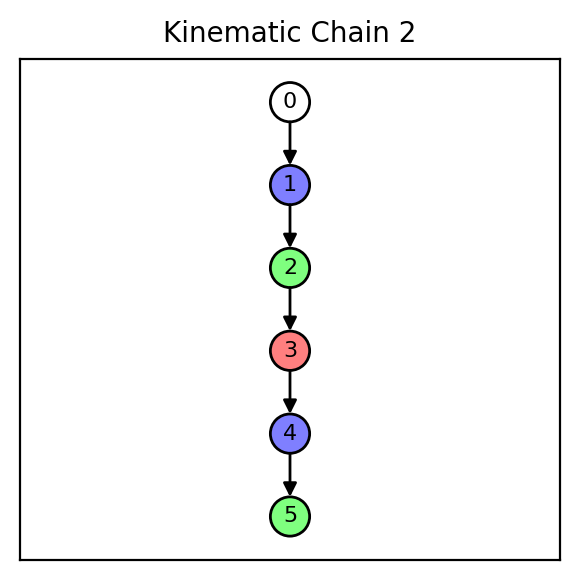

[0/6] joint name:[Base] p:[0 1 0] rpy_deg:[0. 0. 0.]
[1/6] joint name:[Joint1] p:[0.  1.  0.2] rpy_deg:[ 0. -0.  0.]
[2/6] joint name:[Joint2] p:[0.  1.  0.4] rpy_deg:[ 0. -0.  0.]
[3/6] joint name:[Joint3] p:[0.  1.  0.6] rpy_deg:[ 0. -0.  0.]
[4/6] joint name:[Joint4] p:[0.  1.  0.8] rpy_deg:[ 0. -0.  0.]
[5/6] joint name:[EE] p:[0. 1. 1.] rpy_deg:[ 0. -0.  0.]


In [3]:
chain2 = KinematicChainClass(name='Kinematic Chain 2')
chain2.add_joint(name='Base',p=np.array([0,1,0]),R=rpy2r(np.radians([0,0,0])))
chain2.add_joint(name='Joint1',a=np.array([0,0,1]),parent_name='Base',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain2.add_joint(name='Joint2',a=np.array([0,1,0]),parent_name='Joint1',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain2.add_joint(name='Joint3',a=np.array([1,0,0]),parent_name='Joint2',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain2.add_joint(name='Joint4',a=np.array([0,0,1]),parent_name='Joint3',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain2.add_joint(name='EE',a=np.array([0,1,0]),parent_name='Joint4',
                 p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
# Plot chain
chain2.plot_chain_graph(figsize=(3,3),node_size=200,font_size_node=8,font_size_title=10)
# Print chain info
chain2.forward_kinematics()
chain2.print_chain_info()

### Plot chain

In [4]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[0] images removed.


In [5]:
# Configuration
PLOT_EVERY = 20
SAVE_VID   = False
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[20] SAVE_VID:[0]


Pressed ESC
Quitting.


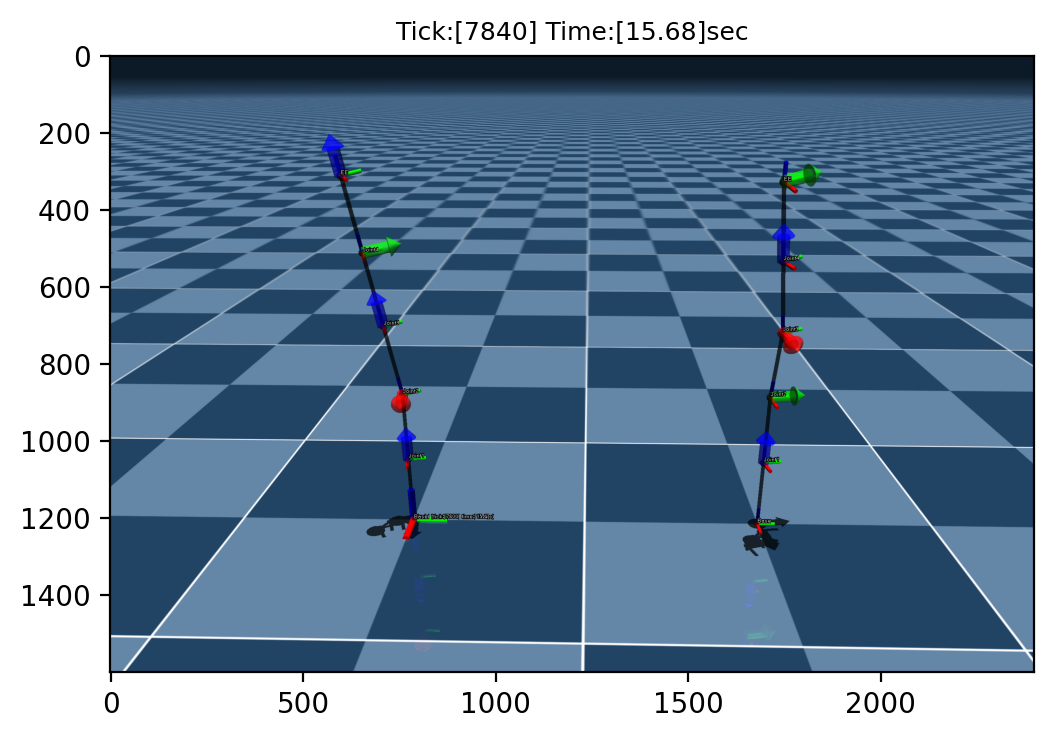

Done.


In [6]:
# Loop
xml_path = '../asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='Floor',rel_xml_path=xml_path,VERBOSE=False)
env.init_viewer(viewer_title='Kinematic Chain',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=177,distance=2.0,elevation=-28,lookat=[0.0,0.1,0.65],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    # Step
    env.step()
    
    # Forward Kinematics
    joint_names = ['Joint1','Joint2','Joint3','Joint4','EE']
    qs = (np.radians(90)*np.sin(env.get_sim_time()*1.0),)*len(joint_names)
    chain1.set_joint_q(joint_names=joint_names,qs=qs)
    chain1.forward_kinematics()
    chain2.set_joint_q(joint_names=joint_names,qs=qs)
    chain2.forward_kinematics()
    
    # Render
    if (env.tick==1) or ((env.tick%PLOT_EVERY)==0):
        env.plot_T(p=np.zeros(3,),R=np.eye(3),
                   PLOT_AXIS=True,axis_len=0.1,axis_width=0.01,PLOT_SPHERE=False,
                   label='World (tick:[%d] time:[%.1f]s)'%(env.tick,env.get_sim_time()))
        # Plot chain in MuJoCo
        chain1.plot_chain_mujoco(env)
        chain2.plot_chain_mujoco(env)
        env.render()
        if SAVE_VID:
            # Save iamges
            png_path = '../temp/kin_chain_%05d.png'%(env.tick)
            create_folder_if_not_exists(png_path)
            image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
            cv2.imwrite(png_path,image)
        
    # Save the current view
    if env.loop_every(HZ=10): scene_img = env.grab_image()

# Plot the final scene1
plt.figure(figsize=(6,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.") 

### Make video

In [7]:
if SAVE_VID:
    # Show video
    png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
    frames = []
    for png_path in png_paths:
        img_bgr = cv2.imread(png_path)
        img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
        frames.append(img_rgb)
    media.show_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),width=500)
    # Save video to mp4
    vid_path = '../vid/kin_chain.mp4'
    create_folder_if_not_exists(vid_path)
    media.write_video(images=frames,fps=int(1/env.dt/PLOT_EVERY),path=vid_path)
    print ("[%s] saved."%(vid_path))

In [8]:
# Remove existing images
png_paths = sorted(glob.glob('../temp/kin_chain_*.png'))
for png_path in png_paths:
    os.remove(png_path)
print ("[%d] images removed."%(len(png_paths)))

[0] images removed.


### Compute a Jacobian Matrix

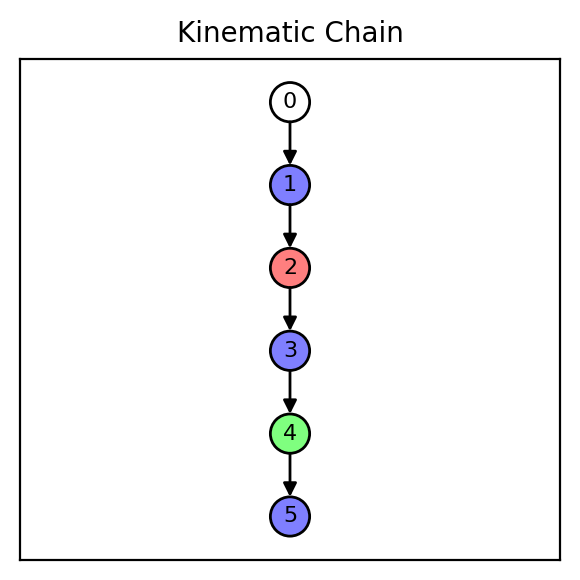

[0/6] joint name:[Base] p:[0 0 0] rpy_deg:[0. 0. 0.]
[1/6] joint name:[Joint1] p:[0.  0.  0.2] rpy_deg:[ 0. -0.  0.]
[2/6] joint name:[Joint2] p:[0.  0.  0.4] rpy_deg:[ 0. -0.  0.]
[3/6] joint name:[Joint3] p:[0.  0.  0.6] rpy_deg:[ 0. -0.  0.]
[4/6] joint name:[Joint4] p:[0.  0.  0.8] rpy_deg:[ 0. -0.  0.]
[5/6] joint name:[EE] p:[0. 0. 1.] rpy_deg:[ 0. -0.  0.]


In [9]:
chain = KinematicChainClass(name='Kinematic Chain')
chain.add_joint(name='Base',p=np.array([0,0,0]),R=rpy2r(np.radians([0,0,0])))
chain.add_joint(name='Joint1',a=np.array([0,0,1]),parent_name='Base',
                p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain.add_joint(name='Joint2',a=np.array([1,0,0]),parent_name='Joint1',
                p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain.add_joint(name='Joint3',a=np.array([0,0,1]),parent_name='Joint2',
                p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain.add_joint(name='Joint4',a=np.array([0,1,0]),parent_name='Joint3',
                p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
chain.add_joint(name='EE',a=np.array([0,0,1]),parent_name='Joint4',
                p_offset=np.array([0,0,0.2]),R_offset=rpy2r(np.radians([0,0,0])))
# Plot chain
chain.plot_chain_graph(figsize=(3,3),node_size=200,font_size_node=8,font_size_title=10)
# Print chain info
chain.forward_kinematics()
chain.print_chain_info()

In [10]:
# Loop
xml_path = '../asset/object/floor_sky.xml'
env = MuJoCoParserClass(name='Floor',rel_xml_path=xml_path,VERBOSE=False)
env.init_viewer(viewer_title='Kinematic Chain',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=177,distance=2.0,elevation=-28,lookat=[0.0,0.1,0.65],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,
                  jointrgba=[0.2,0.6,0.8,0.6])
env.reset()
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    # Step
    env.step()
    
    # Forward Kinematics
    joint_names = ['Joint1','Joint2','Joint3','Joint4','EE']
    qs = (np.radians(90)*np.sin(env.get_sim_time()*1.0),)*len(joint_names)
    chain.set_joint_q(joint_names=joint_names,qs=qs)
    chain.forward_kinematics()
    
    # Render
    if (env.tick==1) or ((env.tick%PLOT_EVERY)==0):
        env.plot_T(p=np.zeros(3,),R=np.eye(3),
                   PLOT_AXIS=True,axis_len=0.1,axis_width=0.01,PLOT_SPHERE=False,
                   label='World (tick:[%d] time:[%.1f]s)'%(env.tick,env.get_sim_time()))
        # Plot chain in MuJoCo
        chain.plot_chain_mujoco(env)
        env.render()
        
# Close viewer
env.close_viewer()
print ("Done.") 

Pressed ESC
Quitting.
Done.
